In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [0]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [0]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


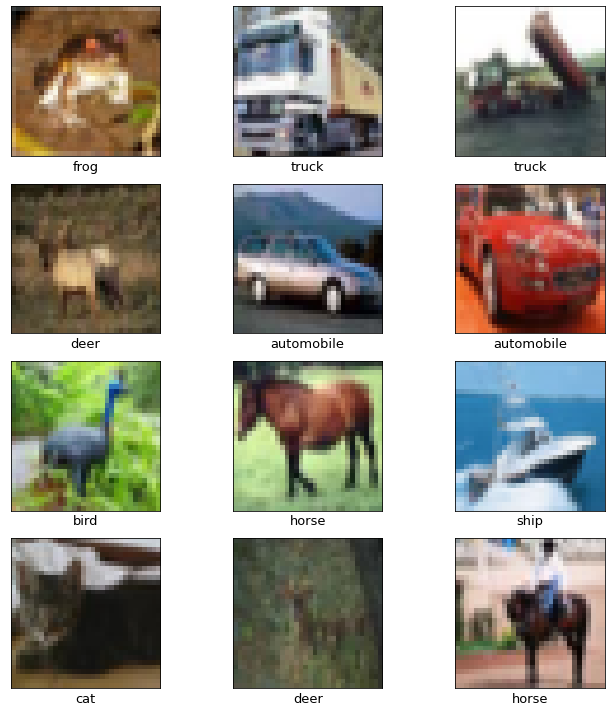

In [0]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()    
plt.show()

In [0]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(
    train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

In [0]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [0]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [0]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

For more read check the original [Residual Net paper](https://arxiv.org/pdf/1512.03385.pdf). 

Then main idea is to train a very deep netowrk without degradation. 

Let's describe the Residual block in short. Below is a simplified picture-- 
![resnet](https://drive.google.com/uc?id=1eSstMpN_x05-A_ScoUfx12fMU1Fcjvtj)

Why Resnet work? 

Below is Andrew Ng's explanation : 

Consider the activation function of layer l is $a^{[l]}$. In general in a node first we apply a linear operation (depending upon the layer weights and biases) and then apply the non-linearity (sigmoid, tanh, Relu etc.) operator. To write it in more simple terms, with reference to the figure -- 

$Z^{[l + 1]} = W^{[l + 1]}\, a^{[l]} + b^{[l+1]};\, a^{[l + 1]} = g\left(Z^{[l + 1]} \right)$ ... (1)

$Z^{[l + 2]} = W^{[l + 2]}\, a^{[l + 1]} + b^{[l+2]};\, a^{[l + 2]} = g\left(Z^{[l + 2]} \right)$ ... (2)

Including the Skip connection the activation $a^{[l]}$ will be sent (copied) much further into the network and add before applying the non-linearity. Let's see how the second equation changes in Resnet-- 

$Z^{[l + 2]} = W^{[l + 2]}\, a^{[l + 1]} + b^{[l+2]};\, a^{[l + 2]} = g\left(Z^{[l + 2]} + a^{[l]} \right)$ ...(3). 

The idea is to take many such resnet block and stack them together. The reason we can increase the depth of the network with training error continulously going down in resnet is becasue of the identity blocks. In equation 3, assuming L2 regularization, we can see that weights and biases would shrink (go close to zero) and thus $a^{[l+2]} = g(\sim 0+a^{[l]})$. With relu non-linearity function this would be $a^{[l+2]} \approx a^{[l]}$. Thus going deep doesn't hurt the performance as learning the identity function is easy and, in the process we can learn some more important features.  

### Residual Block and Resnet :

Let's deep dive to learn the ingenious idea behind the proposal of ResNet by K.He. et.al. For more details always check the original paper. 

The main motivation of the work is to address the degradation problem in deep network. Adding more layers to a sufficiently deep neural network would first see a saturation in accuracy and then the accuracy degrades. He et.al. presented the following picture of train and test error with Cifar-10 data-set using vanilla net-- 
![resnet_degradation](https://drive.google.com/uc?id=1jAqwXV01_nRTH1g6L9aZe2m1pPPHZosn)

As the figure shows [reference: [Resnet paper](https://arxiv.org/pdf/1512.03385.pdf)] going deeper eventually worsens the performance of the network on the data-set. 

Another way of thinking about this problem is to consider a sufficiently deeper network calculates strong set of features needed for the task in hand (ex: image classification). If we add one more layer to this network what would happen? Before the addition if the model could already calculate some strong features then the added layer should be able to just copy the features i.e. perform an identity mapping, which seems to be a very simple task but it is far from reality. 

Let's understand this via some simple mathematical concepts. 
Consider a DNN architecture including learning rate and other hyperparameter that can reach a class of functions $\mathcal F$. So for all $f \in \mathcal F$ there exist some sort of parameters $W$ which can be obtained after training with some particular data-set. If $f^*$ is the function we would really like to find but if it is not in $\mathcal F$ then we try to find $f_{\mathcal F}^*$ within $\mathcal F$. 

It would be reasonable to assume if we design a powerful architecture $\mathcal F_1$, we should arrive at a better outcome i.e. $f_{\mathcal F_1}^*$ is better than $f_{\mathcal F}^*$. But if $\mathcal F \nsubseteq \mathcal {F_1}$, then there is no guarantee that this should happen. In fact, $f_{\mathcal F_1}$ may be even worse. This is actually the degradation problem and what we encounter in real life.

So main point is only if the complex and deeper neural net function classes contain the simpler and shallower ones, then we can guarantee that the deeper network will increase the expressive power of the network.     

### Residual Block 

The main building block of the ResNet are the residual blocks. The framework strictly stems from the previous ideas discussed. 

If we consider $x$ as input and the desired mapping from input to output is denoted by $g(x)$. We stack layers (including non-linearity coming from the activation function) to fit a different function $f(x) : = g(x) - x $. The original mapping is then recast to $f(x) + x$. He et.al. hypothesized that it is easier to optimize the residual $(f)$ than the original mapping $(g)$. The basic residual block is shown below --
![residual_block](https://drive.google.com/uc?id=1HvMABUULlzJ9WS8jrhN9uaJIM71l0tyV)

One more important point to remember is about the dimension of the input $x$ and output $f(x)$. The building block can usually be defined as -- 
$y = f(x, \{W_i\}) + x$; 

and the network learns the residual mapping $f$. In the figure above there are 2 weight layers and an activation function in between in the residual block.  So $f = W_2\sigma (W_1x)$. Then $f+x$ is performed by elementwise addition. The skip/shortcut connection doesn't use any additional parameters. The dimesion of $f$ and $x$ must be equal, if this is not the case, then one can perform a linear projection $W_s$  by shortcut connection to match dimension. A square matrix $W_s$ can also be used ($y = f(x, \{W_i\}) + W_sx $) but the authors suggested that the identity conncection is sufficient to address the degradation problem. 

With all these in mind, let's implement ResNet. 

### Build ResNet with TensorFlow 

I applied the activation after the batch norm but this is actually highly debatable on where to apply batch norm, before or after the activation layer. Here's a [stack post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) on the topic.  Also instead of a 2 block skip connection we will use 3 block skip connection (discussed later). 
Let's just briefly some other important points related to the original resnet architecture, below is a picture of He et.al. paper --
![res_arch](https://drive.google.com/uc?id=1y2JUXhfuSAK0QFOHWJhmpToZnHkNa1lW)  

Dimension remains same in solid line shortcuts and increases for dotted lines. 

The identity shorcut connections are directly used when input and output are of same dimensions. But when the dimensions are different the authors considered two options--

* Skip connection performs identity mapping but use zero padding for increased dimension. So no extra paramter added. 
* The projection shortcut (including matrix $W_s$ in the equation above) used to match dimension by $1\times 1 $ convlolutions. For both options when the shortcuts go across 2 feature maps of 2 sizes, they are performed with strides of 2.     

We will be working with a rather deep resnet-- 50 layers and we will follow the method authors described. For 50/100/150 layers authors used 3 blocks skip connection, as shown in the picture below-- 
![res50net](https://drive.google.com/uc?id=1k9fbtyQgCV1kD9IFjIeQFws58K8Pg4-6) 

The stacked 3 layers have filters $1\times 1, 3\times 3, 1\times 1$, where $1\times 1$ layers increase and decrease the dimension and $3\times 3$ layer acts as bottleneck with smaller input/output dimensions. As can be seen in the original resnet structure after the first pooling there's no pooling layer. So the dimension reduction is happening via $1\times 1$ convolution with strides 2.    

With the above picture and the important info let's build the architecture.   

In [0]:
def res_identity(x, filters): 
  ''' renet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [0]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [0]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [0]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    

In [0]:
resnet50_model = resnet50()

In [0]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [0]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [0]:
batch_size=batch_size # test with 64, 128, 256

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=160, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/160
625/625 [==============================] - 35s 56ms/step - loss: 14.9215 - acc: 0.3326 - val_loss: 506558.7188 - val_acc: 0.1000 - lr: 0.0010
Epoch 2/160
625/625 [==============================] - 34s 55ms/step - loss: 8.4044 - acc: 0.3542 - val_loss: 7.3911 - val_acc: 0.1516 - lr: 0.0010
Epoch 3/160
625/625 [==============================] - 34s 54ms/step - loss: 5.7288 - acc: 0.3769 - val_loss: 5.0420 - val_acc: 0.3398 - lr: 0.0010
Epoch 4/160
625/625 [==============================] - 34s 54ms/step - loss: 4.6321 - acc: 0.4067 - val_loss: 4.1799 - val_acc: 0.3364 - lr: 0.0010
Epoch 5/160
625/625 [==============================] - 34s 54ms/step - loss: 4.0283 - acc: 0.4049 - val_loss: 3.8404 - val_acc: 0.2596 - lr: 0.0010
Epoch 6/160
625/625 [==============================] - 34s 55ms/step - loss: 3.5099 - acc: 0.4195 - val_loss: 407.8103 - val_acc: 0.1000 - lr: 0.0010
Epoch 7/160
625/625 [==============================] - 35s 56ms/step - loss: 4.2395 - acc: 0.3376 - val_

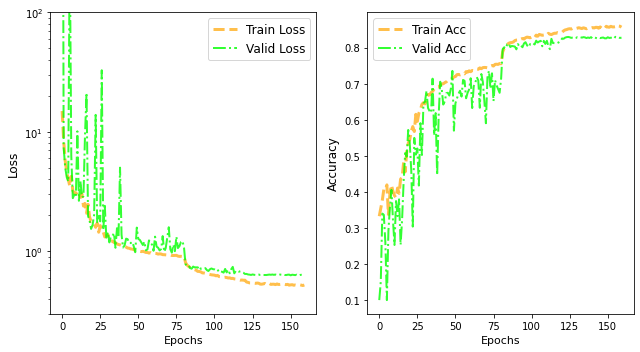

In [0]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [0]:
from google.colab import  drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Classification Report:

              precision    recall  f1-score   support

    airplane       0.51      0.89      0.65      1000
  automobile       0.89      0.93      0.91      1000
        bird       0.86      0.68      0.76      1000
         cat       0.79      0.54      0.64      1000
        deer       0.86      0.72      0.79      1000
         dog       0.83      0.69      0.75      1000
        frog       0.78      0.93      0.85      1000
       horse       0.90      0.85      0.87      1000
        ship       0.93      0.87      0.90      1000
       truck       0.87      0.88      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000



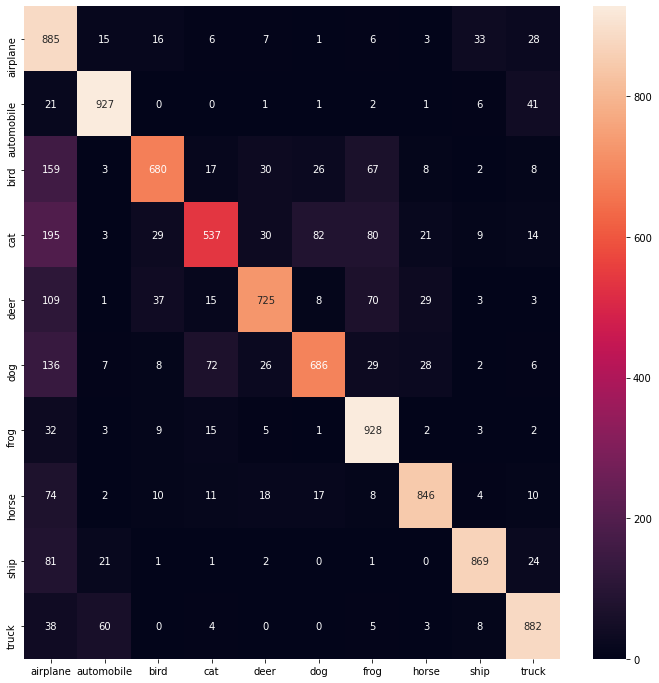

In [0]:
pred_class_resnet50 = resnet50_model.predict(test_im)

conf_matrix(pred_class_resnet50)

In [0]:
### Resutls on Test Data; 
## Check the performance on the test data 
test_result = resnet50_model.evaluate(test_im, test_lab_categorical, verbose=0)

print ("ResNet50 loss: ", test_result[0])
print ("ResNet50 accuracy: ", test_result[1])

ResNet50 loss:  0.6563612818717957
ResNet50 accuracy:  0.8191999793052673
